In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from jax import vmap, jit
from fastprogress import progress_bar
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from bayes_ca import prox_grad
import bayes_ca.inference as core

In [2]:
@jit
def gibbs_sample_subject_means(key,
                         subj_obs, 
                         sigmasq_obs, 
                         global_means, 
                         sigmasq_subj, 
                         mu_pri, 
                         sigmasq_pri, 
                         hazard_rates):
    num_subjects = subj_obs.shape[0]
    effective_sigmasq = 1 / (1 / sigmasq_obs + 1 / sigmasq_subj)
    effective_emissions = effective_sigmasq * (subj_obs / sigmasq_obs + global_means / sigmasq_subj)

    _sample_one = lambda key, y: core.gaussian_cp_posterior_sample(
        key, y, hazard_rates, mu_pri, sigmasq_pri, effective_sigmasq)[1]
    return vmap(_sample_one)(jr.split(key, num_subjects), effective_emissions)

In [3]:
@jit
def prox_update_global_mean(stepsize,
                            global_means,
                            subj_means, 
                            sigmasq_subj, 
                            mu_pri, 
                            sigmasq_pri, 
                            hazard_rates):
    # Use exponential family magic to compute gradient of the 
    # smooth part of the objective (not including the CP prior)
    _, _, _, expected_subj_means = core.gaussian_cp_smoother(
        global_means, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj)
    g = 1 / sigmasq_subj * jnp.sum(subj_means - expected_subj_means, axis=0)   # sum over subjects
    # jax.debug.breakpoint()

    # Compute the proximal update by taking a step in the direction of the gradient
    # and using the posterior mode to find the new global states
    effective_emissions = global_means + stepsize * g
    new_global_means = core.gaussian_cp_posterior_mode(
        effective_emissions, hazard_rates, mu_pri, sigmasq_pri, jnp.repeat(stepsize, num_features))[1]
    return new_global_means, g

## Simulate from the hierarchical model

In [4]:
key = jr.PRNGKey(0)

# data settings
num_subjects = 2
num_features = 1
num_timesteps = 300

# model settings
num_states = num_timesteps
max_duration = num_states + 1
hazard_prob = 0.01

mu_pri = 0.0
sigmasq_pri = 3.0**2
sigmasq_subj = 0.5
sigmasq_obs = 0.05**2

hazard_rates = hazard_prob * jnp.ones(max_duration)
hazard_rates = hazard_rates.at[-1].set(1.0)

mu_pri = core._safe_handling_params(mu_pri, num_features)
sigmasq_pri = core._safe_handling_params(sigmasq_pri, num_features)
sigmasq_subj = core._safe_handling_params(sigmasq_subj, num_features)

In [5]:
# First sample the global states
this_key, key = jr.split(key)
# handles multiple features via broadcasting
_, true_global_means = core.sample_gaussian_cp_model(key, num_timesteps, hazard_rates, mu_pri, sigmasq_pri)

# Sample means for each subject given the global mean
this_key, key = jr.split(key)
_sample_one_mean = lambda key: core.gaussian_cp_posterior_sample(
    key, true_global_means, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj)
_, true_subj_means = vmap(_sample_one_mean)(jr.split(this_key, num_subjects))

# Finally, sample observations for each subject
this_key, key = jr.split(key)
subj_obs = tfd.Normal(true_subj_means, jnp.sqrt(sigmasq_obs)).sample(seed=this_key)


In [6]:
true_global_means = jnp.concatenate((
    jnp.zeros((150, num_features)),
    jnp.ones((150, num_features))
))

true_subj_one = jnp.concatenate((
    jnp.zeros((125, num_features)),
    jnp.ones((175, num_features))  
))
true_subj_two = jnp.concatenate((
    jnp.zeros((175, num_features)),
    jnp.ones((125, num_features))  
))

# plt.plot(true_subj_one[...,0], label='subject-1')
# plt.plot(true_subj_two[...,0], label='subject-2')
# plt.plot(true_global_means[...,0], label='global')
# plt.legend()

In [7]:
true_subj_means = jnp.stack((true_subj_one, true_subj_two), axis=0)

# Finally, sample observations for each subject
this_key, key = jr.split(key)
_sample_one_obs = lambda key: tfd.Normal(true_subj_means, jnp.sqrt(sigmasq_obs)).sample(seed=key)

_, subj_obs = vmap(_sample_one_obs)(jr.split(this_key, num_subjects))

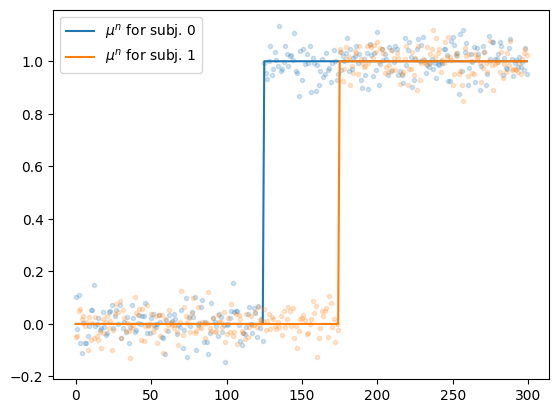

In [8]:
for i in range(2):
    l = plt.plot(true_subj_means[i], alpha=1, label=f'$\mu^n$ for subj. {i}')[0]
    plt.plot(subj_obs[i], '.', color=l.get_color(), alpha=0.2)
plt.legend()

## Sample conditional distribution for each subject

The effective observations for each subject are the weighted average of its observations and the global mean.

In [9]:
key = jr.PRNGKey(0)
subj_means = gibbs_sample_subject_means(
    key, subj_obs, sigmasq_obs, true_global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

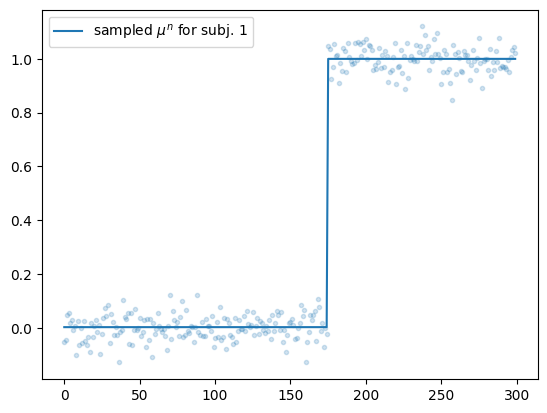

In [10]:
for i in range(1, 2):
    l = plt.plot(subj_means[i], alpha=1, label=f'sampled $\mu^n$ for subj. {i}')[0]
    plt.plot(subj_obs[i], '.', color=l.get_color(), alpha=0.2)
plt.legend()

In [11]:
def _calculate_f_g(mu_0, mu_n):
    """"""
    log_normalizer, _, _, E_mu_n = core.gaussian_cp_smoother(
        mu_0, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj
    )
    f = -0.5 / sigmasq_subj * jnp.sum((mu_n - mu_0) ** 2) - log_normalizer
    g = 1 / sigmasq_subj * (mu_n - E_mu_n)
    return f, g

Text(0, 0.5, '$f$')

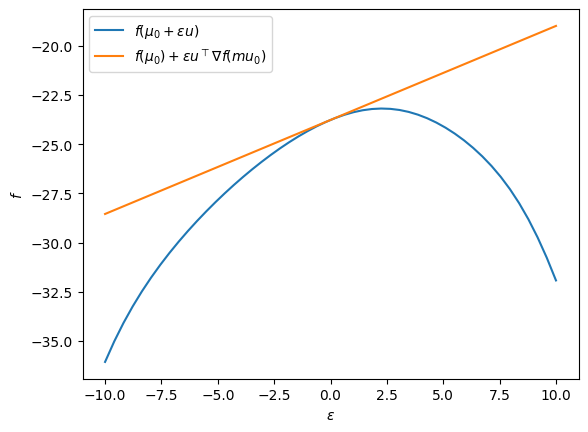

In [12]:
key = jr.PRNGKey(1234)
k1, k2 = jr.split(key, 2)

# Randomly create global and single subject means
mu0 = jr.normal(k1, (num_timesteps, num_features))
mun = subj_means[0]

# Pick a random direction in which to visualize the gradient
u = jr.normal(k2, (num_timesteps, num_features))
u /= jnp.sqrt(jnp.sum(u**2))

# evaluate the function at a grid of points along this direction
eps = jnp.linspace(-10, 10)
f_true = vmap(lambda e: _calculate_f_g(mu0 + e * u, mun)[0])(eps)

# evaluate the first order taylor approximation along this direction
f0, g0 = _calculate_f_g(mu0, mun)
f_approx = vmap(lambda e: f0 + jnp.sum(e * u * g0))(eps)

plt.plot(eps, f_true, label=r"$f(\mu_0 + \epsilon u)$")
plt.plot(eps, f_approx, label=r"$f(\mu_0) + \epsilon u^\top \nabla f(mu_0)$")
plt.legend()
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$f$")

## Proximal gradient descent

In [38]:
# %pdb
from jaxtyping import Array, Float
from copt import minimize_proximal_gradient
from jax.flatten_util import ravel_pytree



# The optimization library operates on parameter vectors.
# Wrap the objective and gradient above to take take flattened vectors
# Use tree flatten and unflatten to convert params x0 from PyTrees to flat arrays
x0 = jnp.average(subj_obs, axis=0)
# x0 = 0.5 * jnp.ones((num_timesteps, num_features))
x0_flat, unravel = ravel_pytree(x0)


# Compute the function and its gradient, using the 2d params and all the hypers
def _objective(global_means: Float[Array, "num_timesteps num_features"],
               subj_means: Float[Array, "num_subjects num_timesteps num_features"],
               mu0: Float,
               sigmasq0: Float,
               sigmasq_subj: Float,
               hazard_rates: Float[Array, "max_duration"],):
    
    """
    Compute the log probability as a function of the global means
    """
    log_normalizer, _, _, _ = core.gaussian_cp_smoother(
        global_means, hazard_rates, mu0, sigmasq0, sigmasq_subj
    )

    def _single_objective(subj_mean):
        return -0.5 / sigmasq_subj * jnp.sum((subj_mean - global_means) ** 2) - log_normalizer
    
    return -1 * vmap(_single_objective)(subj_means).sum()


def _grad_objective(global_means: Float[Array, "num_timesteps num_features"],
                    subj_means: Float[Array, "num_subjects num_timesteps num_features"],
                    mu0: Float,
                    sigmasq0: Float,
                    sigmasq_subj: Float,
                    hazard_rates: Float[Array, "max_duration"],):
    _, _, _, expected_subj_means = core.gaussian_cp_smoother(
            global_means, hazard_rates, mu0, sigmasq0, sigmasq_subj
        )
    
    def _single_grad(subj_mean):
        return 1 / sigmasq_subj * (subj_mean - expected_subj_means)
    
    return -1 * vmap(_single_grad)(subj_means).sum(axis=0)

# Flatten the objective and gradient to work with copt
def _flat_objective(_flat_global_means,
                    subj_means: Float[Array, "num_subjects num_timesteps num_features"],
                    mu0: Float,
                    sigmasq0: Float,
                    sigmasq_subj: Float,
                    hazard_rates: Float[Array, "max_duration"],): 
    
    global_means = unravel(_flat_global_means)
    return _objective(global_means,
                      subj_means,
                      mu0,
                      sigmasq0,
                      sigmasq_subj,
                      hazard_rates)

def _flat_grad_objective(_flat_global_means,
                         subj_means: Float[Array, "num_subjects num_timesteps num_features"],
                         mu0: Float,
                         sigmasq0: Float,
                         sigmasq_subj: Float,
                         hazard_rates: Float[Array, "max_duration"],): 
    
    global_means = unravel(_flat_global_means)
    g = _grad_objective(global_means,
                        subj_means,
                        mu0,
                        sigmasq0,
                        sigmasq_subj,
                        hazard_rates)
    return ravel_pytree(g)[0]

# Write a flat prox operator
def _flat_prox(
    _flat_global_means,
    step_size: Float,
    mu0: Float,
    sigmasq0: Float,
    hazard_rates: Float[Array, "max_duration"],
    ):
    """
    Compute the proximal update by taking a step in the direction of the gradient
    and using the posterior mode to find the new global
    """
    global_means = unravel(_flat_global_means)
    x_next = core.gaussian_cp_posterior_mode(global_means, hazard_rates, mu0, sigmasq0, step_size)[1]
    return ravel_pytree(x_next)[0]
    
# Finally, close over the global hyperparameters
f = lambda x: _flat_objective(x, subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates)
g = lambda x: _flat_grad_objective(x, subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates)
prox = lambda x, stepsize: _flat_prox(x, stepsize, mu_pri, sigmasq_pri, hazard_rates)

result = minimize_proximal_gradient(
    fun=jit(f), x0=x0_flat, prox=jit(prox), jac=jit(g), 
)

x = unravel(result.x)

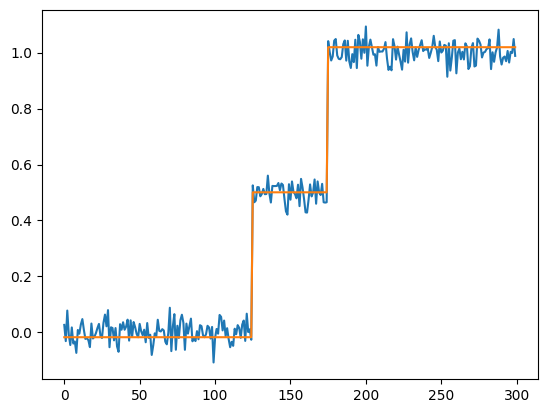

In [39]:
plt.plot(x0[:, 0])
plt.plot(x[:, 0])

In [27]:
x0_flat.shape
print(f(x0_flat))
print(g(x0_flat).shape)
print(prox(x0_flat, 1.0).shape)

356.2383
(300,)
(300,)


In [59]:
%pdb
from jaxopt import ProximalGradient
from bayes_ca.prox_grad import _calculate_f_g, _prox

init_stepsize = 1.0
init_global_means = jnp.average(subj_obs, axis=0)
global_means = init_global_means

pg = ProximalGradient(
    fun=_calculate_f_g,
    prox=_prox, value_and_grad=True, stepsize=-1)
init_vals = (init_global_means)
hyperparams_prox=(hazard_rates)
init_state = pg.init_state(
    init_vals, 
    hyperparams_prox, 
    subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates
)
(params, state) = pg.update(
    init_vals, init_state, hyperparams_prox,
    subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates
)

Automatic pdb calling has been turned OFF


TypeError: _prox() missing 2 required positional arguments: 'hazard_rates' and 'step_size'

In [60]:
stepsize = 5.0
global_means = jnp.average(subj_obs, axis=0)
global_means, g = prox_grad.nesterov_acceleration(
    stepsize, global_means, subj_means, mu_pri, sigmasq_pri, sigmasq_subj, hazard_rates
)

## Compute gradient with respect to the global mean

In [ ]:
# stepsize = 0.1
# global_means = jnp.average(subj_obs, axis=0)

# # with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
# for i in progress_bar(range(100000)):
#     global_means, g = prox_update_global_mean(
#         stepsize, global_means, subj_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

(-0.2, 1.2)

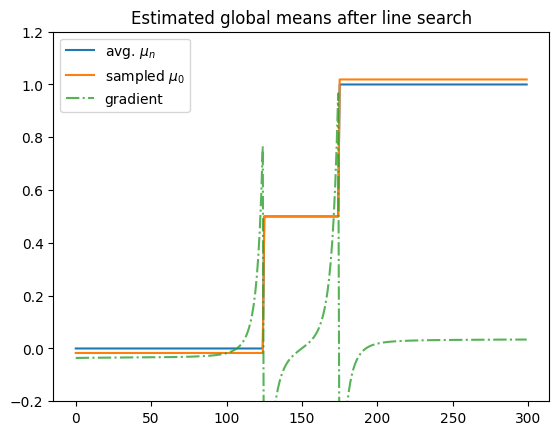

In [61]:
plt.plot(true_subj_means.mean(axis=0), label='avg. $\mu_n$')
plt.plot(global_means, label='sampled $\mu_0$')
plt.plot(g, ls='-.', label='gradient', alpha=0.8)
# plt.axhline(0.5, color='k', ls=':', label='initialization')
plt.title(f'Estimated global means after line search')
plt.legend()
plt.ylim(-0.2, 1.2)

## Put both steps together

In [ ]:
@jit
def step(key,
         stepsize,
         subj_obs, 
         sigmasq_obs, 
         global_means, 
         sigmasq_subj, 
         mu_pri, 
         sigmasq_pri, 
         hazard_rates):
    
    # Sample new subject means
    subj_means = gibbs_sample_subject_means(
        key, subj_obs, sigmasq_obs, global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)
    
    # Update the global mean
    global_means, g = core.backtracking_lsearch(stepsize, global_means, subj_means, sigmasq_subj,
                                                hazard_rates, mu_pri, sigmasq_pri)
    
    return global_means, subj_means, g

In [ ]:
key = jr.PRNGKey(0)
stepsize = 0.1  # FIXME  # backtracking line problem ?
global_means = jnp.average(subj_obs, axis=0)

for itr in progress_bar(range(100)):
    this_key, key = jr.split(key)
    global_means, subj_means, g = step(
        this_key,
        stepsize,
        subj_obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )

In [ ]:
plt.plot(true_global_means, label='true $\mu_0$')
plt.plot(global_means, label='sampled $\mu_0$')
plt.plot(g, ls='-.', label='gradient', alpha=0.8)
# plt.axhline(0.5, color='k', ls=':', label='initialization')
plt.title(f'Estimated global means, {i} iterations')
plt.legend()
plt.ylim(-0.2, 1.2)

In [ ]:
l = plt.plot(subj_means[1], label=f'sampled $\mu^n$ for subj. 1')[0]
plt.plot(subj_obs[1], 'o', color=l.get_color(), alpha=0.1, lw=3)
plt.plot(global_means, label='sampled $\mu^0$')
plt.plot(g, '-.', label='gradient', alpha=0.8)
plt.legend()
plt.ylim(-0.2, 1.2)